## Baseline

In [1]:
# Importando bibliotecas
from libs import *
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Carregando base de dados em um DataFrame do Pandas.

In [2]:
# Definindo dataframe preprocessado antes dos pipelines
df_baseline = pd.read_csv('data/data1.csv')

In [3]:
# Amostra de 10%
#df_baseline = df_baseline.sample(frac=0.1, random_state=42) 

In [4]:
# Dimensões
df_baseline.shape

(36642, 18)

In [5]:
# Definindo colunas numéricas, categóricas e textuais
numeric_features = ['year', 'video_count', 'view_count_x', 'subscriber_count', 
                    'aux_status', 'comment_count_y','dislike_count', 'view_count_y',
                        'like_count', 'video_duration', 'published_at']

categorical_features = ['channel_id','category', 'gender']

textual_features = ['video_title', 'video_desc']

2. Dividindo os dados em treino e teste, de maneira a evitar vazamento de dados (data leakage).

In [6]:
# Separando features (X) e alvo (y)
X = df_baseline.drop(['popularity','video_title', 'video_desc'], axis=1)
y = df_baseline['popularity']

# Dividindo o dataframe em conjunto de treinamento e teste 
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X, y, test_size=0.3, random_state=42)

3. Definindo etapas de pré-processamento para as features numéricas e categóricas.

In [7]:
# Aplicando RobustScaler nas colunas numéricas
scaler = RobustScaler()

X_train_baseline_numeric = scaler.fit_transform(X_train_baseline[numeric_features])
X_test_baseline_numeric = scaler.transform(X_test_baseline[numeric_features])

In [8]:
# 11 features numéricas transformadas
print(X_train_baseline_numeric[0])

[-0.4         1.50127443 -0.2304174  -0.3673031   0.         -0.01924399
 -0.05544933 -0.21257568 -0.2833341  -0.16302187  0.49990914]


In [9]:
# Aplicando OneHotEncoder nas colunas categóricas com handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_baseline_categorical = encoder.fit_transform(X_train_baseline[categorical_features])
X_test_baseline_categorical = encoder.transform(X_test_baseline[categorical_features])

In [10]:
# 3 features categóricas representadas em matriz esparsa
print(X_train_baseline_categorical[0])

  (0, 40)	1.0
  (0, 127)	1.0
  (0, 129)	1.0


In [11]:
# 3 features categóricas representadas em matriz densa
print(X_train_baseline_categorical.toarray()[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]


In [12]:
# Transformando as features categóricas em matriz densa (array) para combinar com outras features no futuro
X_train_baseline_categorical = X_train_baseline_categorical.toarray()
X_test_baseline_categorical = X_test_baseline_categorical.toarray()

4. Concatenando através de `np.hstack` as features transformadas para treino e teste.

In [13]:
# Concatenando todas as features processadas
X_train_baseline_preprocessed = np.hstack((X_train_baseline_numeric,
                                           X_train_baseline_categorical))

X_test_baseline_preprocessed = np.hstack((X_test_baseline_numeric,
                                          X_test_baseline_categorical))

5. Treinando e testando modelo de classificação multiclasse.

In [14]:
# Instanciando modelo para classificação multiclasse
model = SVC(class_weight='balanced', random_state=42)

# Treinando o modelo com os dados de treinamento completos
model.fit(X_train_baseline_preprocessed, y_train_baseline)

# Testando modelo nos dados de teste
prediction = model.predict(X_test_baseline_preprocessed)

6. Imprimindo relatório das métricas de avaliação e matriz de confusão.

In [15]:
# Imprimindo métricas de avaliação do modelo
print('\nRelatório de Classificação:')
cr_baseline = classification_report(y_test_baseline, prediction)
print(cr_baseline)

print('\nMatriz de Confusão:')
cm_baseline = confusion_matrix(y_test_baseline, prediction)
print(cm_baseline)


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      6140
           1       0.81      0.85      0.83      3372
           2       0.80      0.93      0.86      1481

    accuracy                           0.88     10993
   macro avg       0.86      0.89      0.87     10993
weighted avg       0.89      0.88      0.89     10993


Matriz de Confusão:
[[5466  602   72]
 [ 221 2878  273]
 [  16   83 1382]]


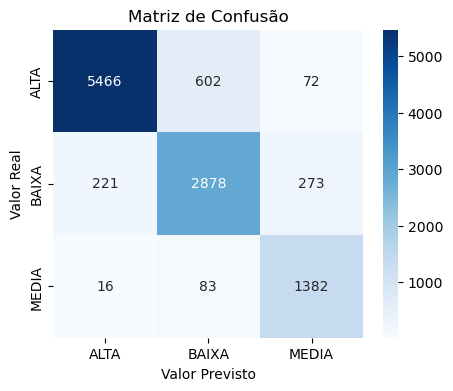

In [16]:
# Plotando a matriz de confusão como heatmap
labels = ['ALTA', 'BAIXA', 'MEDIA']
plot_confusion_matrix(y_test_baseline, prediction, labels)

In [17]:
# Avaliando modelo por feature (categoria)
def evaluate_model_by_feature(X_test, y_test, ft):

    unique_features = X_test[ft].unique()
    
    for feature in unique_features:
        # Filtrando as previsões e rótulos verdadeiros para a categoria específica
        indices = X_test[ft] == feature
        predictions = prediction[indices]
        true_labels = y_test[indices]

        # Avaliando o desempenho para a categoria específica
        print(f'\n{ft}: {feature}')
        print(classification_report(true_labels, predictions, zero_division=1))
        print(confusion_matrix(true_labels, predictions))
        
        # Plotando a matriz de confusão como heatmap
        #labels = ['ALTA', 'BAIXA', 'MEDIA']
        #plot_confusion_matrix(y_test_baseline, prediction, labels)

In [18]:
# Avaliando os resultados por categoria
evaluate_model_by_feature(X_test_baseline, y_test_baseline, 'category')


category: Família
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       120
           1       0.86      0.85      0.85       105
           2       0.57      0.81      0.67        21

    accuracy                           0.87       246
   macro avg       0.80      0.86      0.82       246
weighted avg       0.89      0.87      0.88       246

[[109  11   0]
 [  3  89  13]
 [  0   4  17]]

category: Esporte
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       352
           1       0.86      0.83      0.84       101
           2       0.88      0.95      0.92        86

    accuracy                           0.94       539
   macro avg       0.91      0.92      0.91       539
weighted avg       0.94      0.94      0.94       539

[[342  10   0]
 [  6  84  11]
 [  0   4  82]]

category: Games
              precision    recall  f1-score   support

           0       1.00      0.89   